# Analyze the EEG data using MNE-Python

Basic tools to analyze the EEG data

In [1]:
# %matplotlib widget
%cd ..

c:\Users\ZOMANDRE\OneDrive - Carl Zeiss AG\Dokumente\Git Repos\eeg-hackathon


In [2]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

## load the data

In [52]:
fif_file_path = "data/datasets_raw/fif/sub-01/sub-01_run-005_key_log.fif"
assert os.path.exists(fif_file_path), "File not found"

raw = mne.io.read_raw_fif(fif_file_path, verbose=False, preload=True)
raw

C:\Users\ZOMANDRE\AppData\Local\Temp\ipykernel_33532\2299205619.py:4: RuntimeWarning: This filename (data/datasets_raw/fif/sub-01/sub-01_run-005_key_log.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file_path, verbose=False, preload=True)


<Raw | sub-01_run-005_key_log.fif, 9 x 198707 (794.8 s), ~13.7 MiB, data loaded>

In [ ]:
# signal preprocessing - only relevant for raw data
raw = raw.notch_filter(freqs=[50], picks="eeg")
raw = raw.filter(l_freq=0.1, h_freq=40, picks="eeg")
# raw.drop_channels('Cz')  # drop channels if needed

# whiten the data

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband ed

<Raw | sub-01_run-005_key_log.fif, 8 x 198707 (794.8 s), ~12.1 MiB, data loaded>

In [137]:
# epochs
epochs = mne.Epochs(
    raw,
    mne.find_events(raw, stim_channel='stimulus'),
    baseline=(None, 0),
    detrend=1,
    reject=dict(eeg=300e-6)  # reject epochs with high peak-to-peak amplitude
)

# split in two groups to compare intra variance
epochs1 = epochs[::2]
epochs2 = epochs[1::2]
epochs

580 events found on stim channel stimulus
Event IDs: [8]
Not setting metadata
580 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


<Epochs | 580 events (good & bad), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~16 KiB, data not loaded,
 '8': 580>

In [138]:
# average the epochs time-locked to the key event to create Event-Related Potentials (ERPs)
evoked = epochs.average()
evoked1 = epochs1.average()
evoked2 = epochs2.average()
evoked

    Rejecting  epoch based on EEG : ['Pz', 'PO7']
    Rejecting  epoch based on EEG : ['Pz', 'PO7']


<Evoked | '8' (average, N=579), -0.2 – 0.5 s, baseline -0.2 – 0 s, 7 ch, ~25 KiB>

## Simple plots of the raw data

In [139]:
# simple visualization of the EEG data around a key event
# epochs[:10].plot(picks='eeg', show_scrollbars=False, show_scalebars=False, show=False)

580 events found on stim channel stimulus
Event IDs: [8]


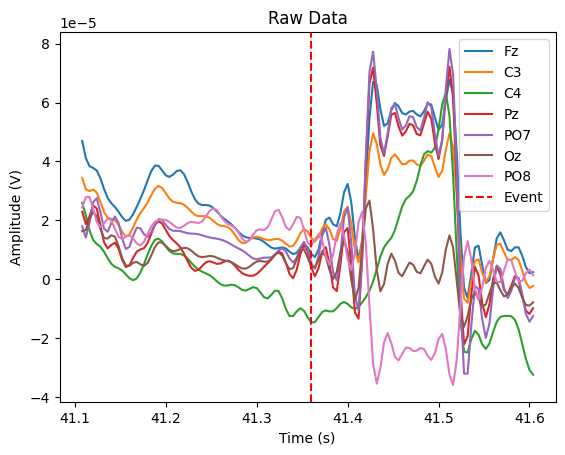

In [149]:
# simple data visualization of a 2sec segment
data = raw.get_data(picks='eeg')

# get indices of stimulus events
events = mne.find_events(raw, stim_channel='stimulus')
events = events[:, 0]
event = events[20]

times = raw.times
duration = 0.5
samples = int(duration * raw.info['sfreq'])
start = int(event - samples / 2)
end = int(event + samples / 2)

fig, ax = plt.subplots()
for i, ch in enumerate(data):
    ch_name = raw.ch_names[i]
    ax.plot(times[start:end], ch[start:end], label=ch_name)

plt.axvline(x=event / raw.info['sfreq'], color='r', linestyle='--', label='Event')

plt.title("Raw Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.legend()
plt.show()

## Frequency analysis

In [141]:
psd_kwargs = dict(fmin=0.1, fmax=60.0)
psd1 = epochs1.compute_psd(**psd_kwargs)
psd2 = epochs2.compute_psd(**psd_kwargs)

Using data from preloaded Raw for 290 events and 176 original time points ...
    Rejecting  epoch based on EEG : ['Pz', 'PO7']
1 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 290 events and 176 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


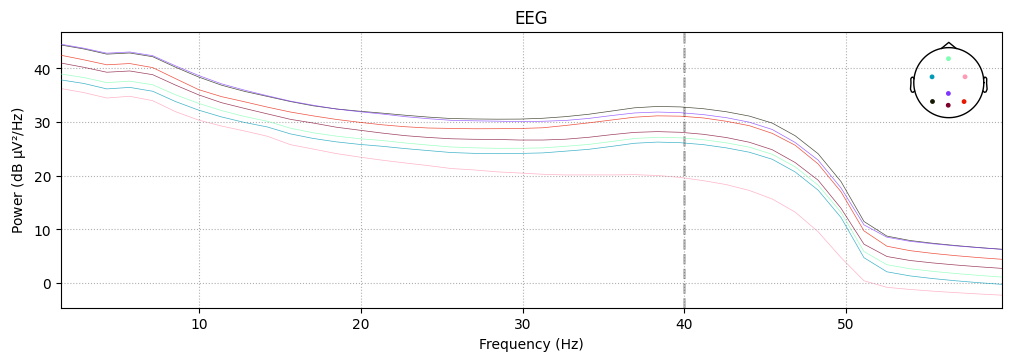

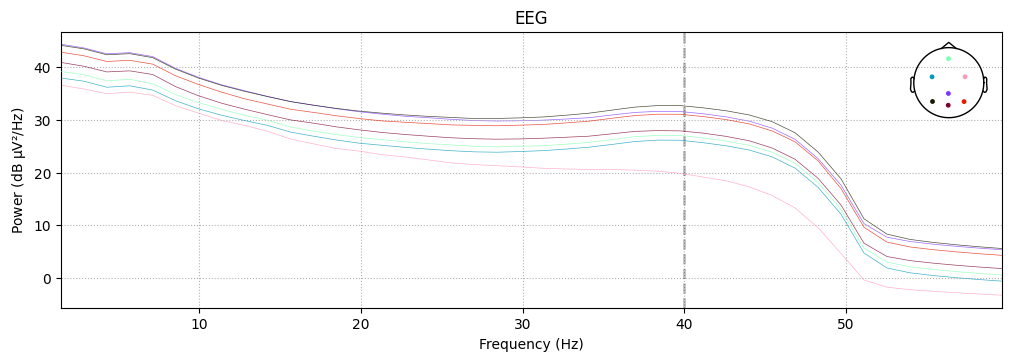

In [142]:
psd1.plot(average=False, spatial_colors=True, show=False)
psd2.plot(average=False, spatial_colors=True, show=False)
plt.show()

Averaging across epochs before plotting...
Averaging across epochs before plotting...


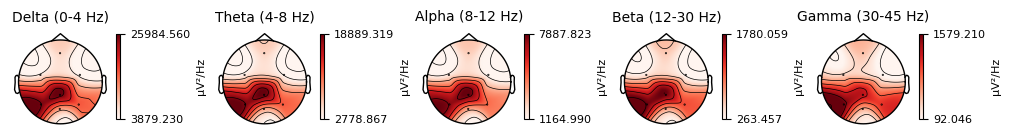

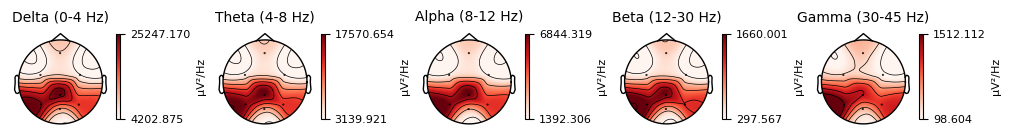

In [143]:
bands = {
    "Delta (0-4 Hz)": (0, 4),
    "Theta (4-8 Hz)": (4, 8),
    "Alpha (8-12 Hz)": (8, 12),
    "Beta (12-30 Hz)": (12, 30),
    "Gamma (30-45 Hz)": (30, 45),
}

psd1.plot_topomap(bands, ch_type='eeg', show=False)
psd2.plot_topomap(bands, ch_type='eeg', show=False)
plt.show()

## Plot ERPs

In [144]:
def snr_var(evoked: mne.Evoked, win=0.1):
    """ calculate the SNR as the ratio of variance of signal to variance of noise
    by computing the variance of pre and post stimulus onset window. 
    """

    assert win <= -1 * evoked.tmin, 'Window size aceeds the epoch length'

    # get the data
    data = evoked.get_data()

    # get the index of the window
    onset_idx = int((-1 * evoked.tmin) * evoked.info['sfreq'])
    win_idx = int(win * evoked.info['sfreq'])

    # get the signal and noise windows
    signal = data[:, onset_idx:onset_idx + win_idx-1]
    noise  = data[:, onset_idx - win_idx:onset_idx-1]

    # compute the variance of signal and noise
    signal_var = np.var(signal, axis=-1)
    noise_var = np.var(noise, axis=-1)

    # compute the SNRs
    snr = signal_var / noise_var

    # get the average SNR over channels
    avg_snr = np.mean(snr, axis=0)
    std_snr = np.std(snr, axis=0)

    return avg_snr, std_snr

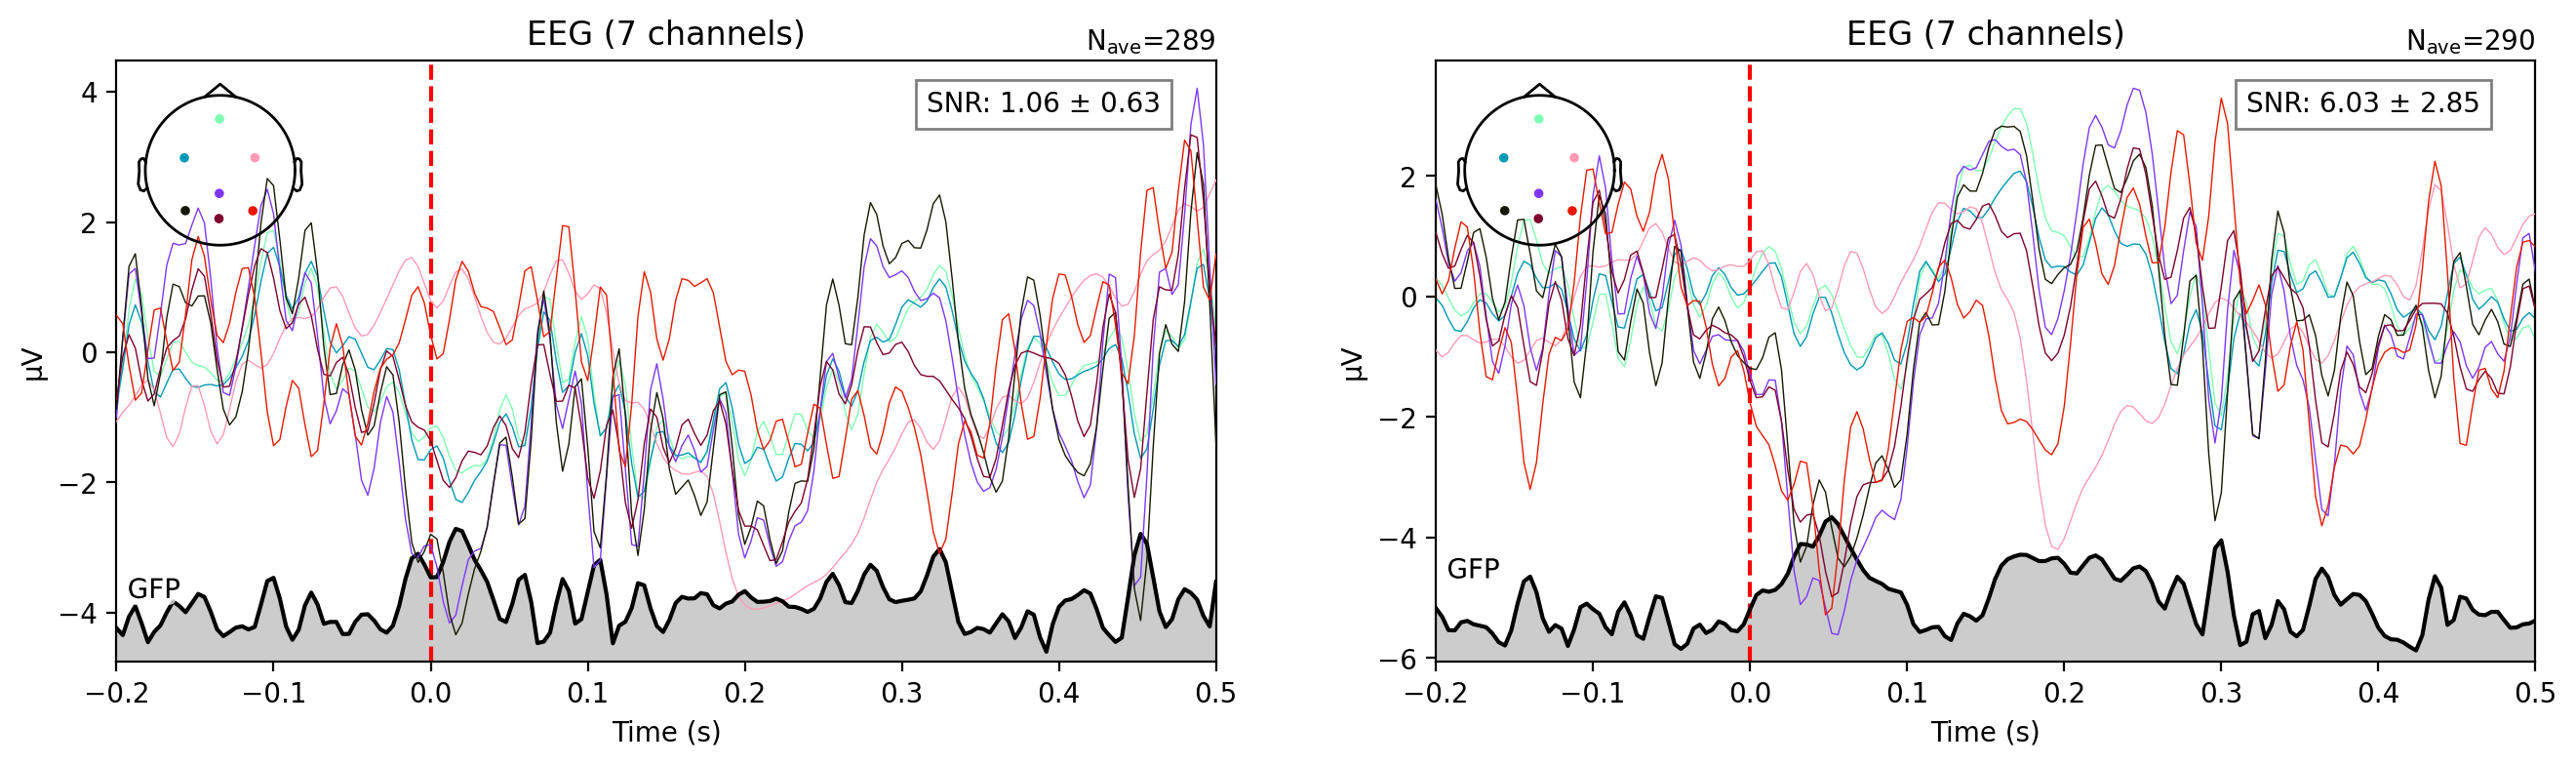

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), dpi=200)

evoked1.plot(spatial_colors=True, gfp=True, axes=axs[0], show=False)
axs[0].axvline(x=0, color='r', linestyle='--', label='Key Event')
snr_avg, snr_std = snr_var(evoked1, win=0.2)
axs[0].text(0.95, 0.95, f'SNR: {snr_avg:.2f} ± {snr_std:.2f}', transform=axs[0].transAxes, 
    verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

evoked2.plot(spatial_colors=True, gfp=True, axes=axs[1], show=False)
axs[1].axvline(x=0, color='r', linestyle='--', label='Key Event')
snr_avg, snr_std = snr_var(evoked2, win=0.2)
axs[1].text(0.95, 0.95, f'SNR: {snr_avg:.2f} ± {snr_std:.2f}', transform=axs[1].transAxes, 
    verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
plt.show()
print()

## Time-Frequency Analysis

In [146]:
# compute TFR
freqs = np.logspace(*np.log10([8, 35]), num=32)
n_cycles = 1 + freqs / 4.0
tfr_kwargs = dict(
    method="morlet",
    freqs=freqs,
    n_cycles=n_cycles,
    average=True,
    return_itc=True,
    use_fft=True,
    decim=4,
)

power1, itc1 = epochs1.compute_tfr(**tfr_kwargs)
power2, itc2 = epochs2.compute_tfr(**tfr_kwargs)

Using data from preloaded Raw for 289 events and 176 original time points ...
Using data from preloaded Raw for 290 events and 176 original time points ...


### Time-Frequency Spectrogram

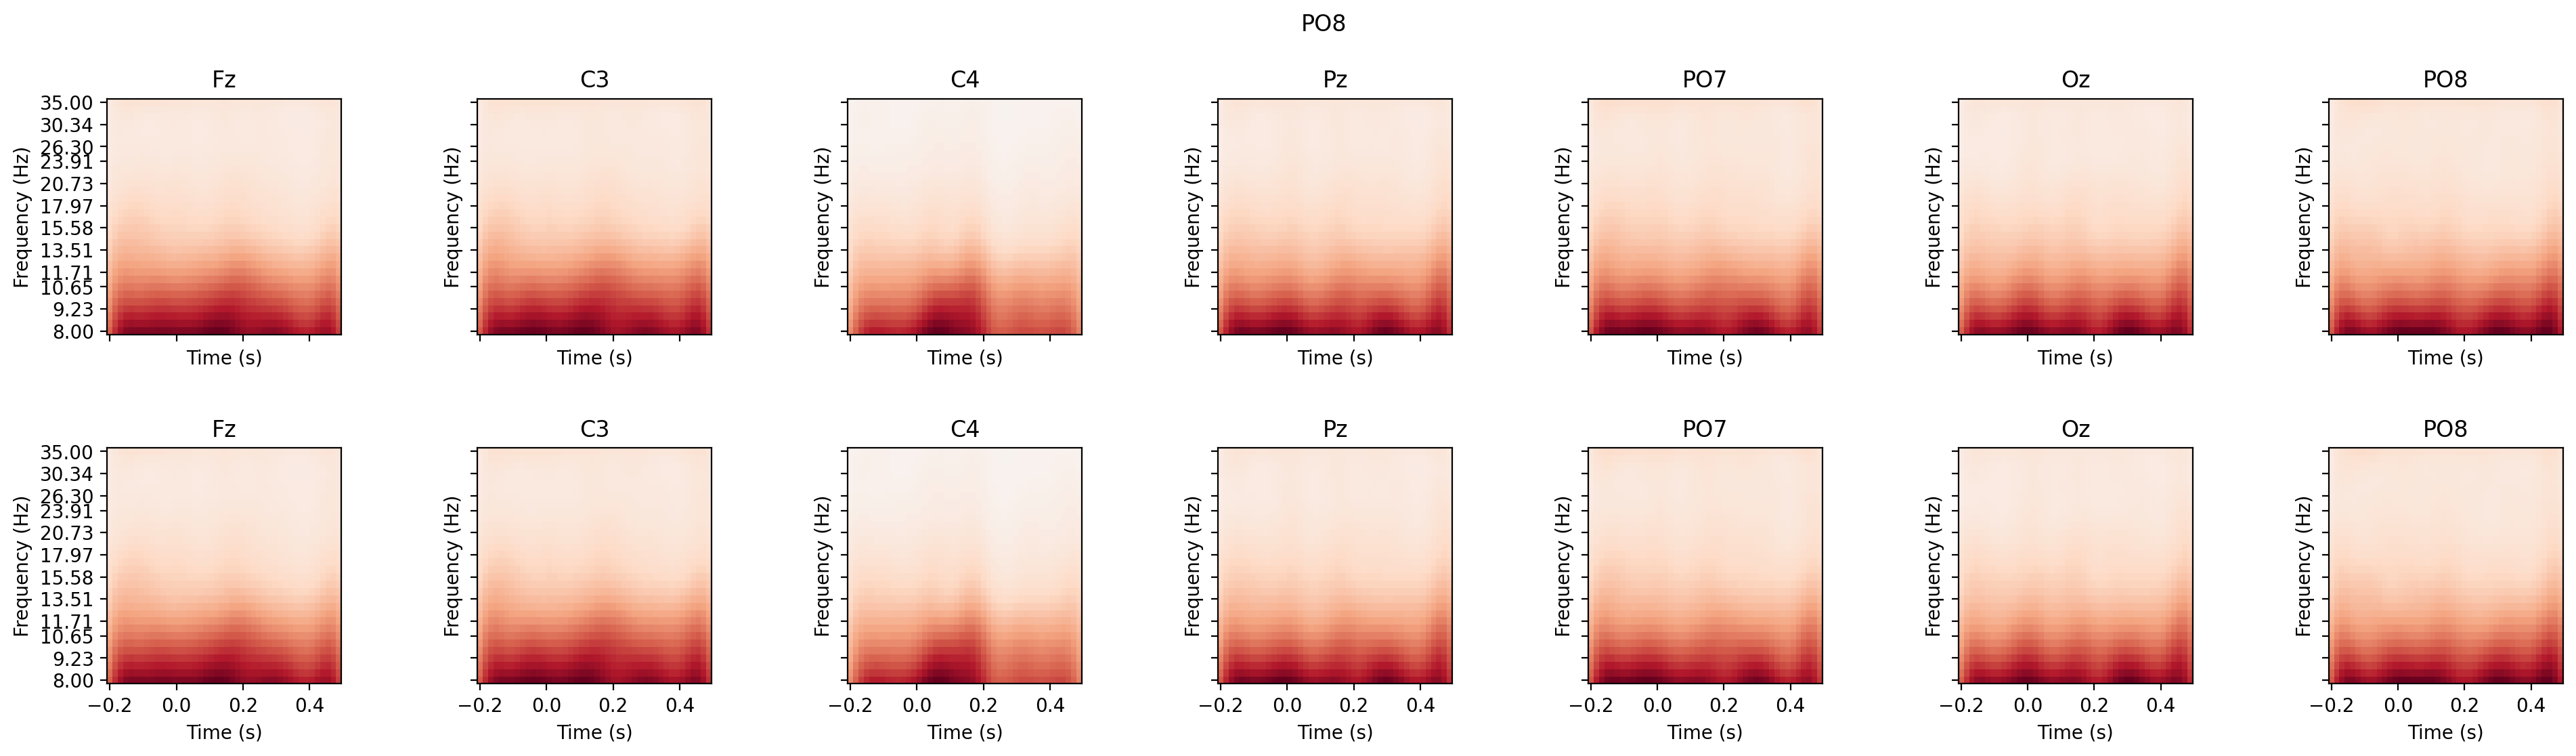

In [147]:
channels = len(power1.ch_names)
fig, axs = plt.subplots(2, channels, figsize=(20, 6), dpi=200, sharey=True, sharex=True)
fig.tight_layout(pad=5.0)
plot_kw = dict(mode="zlogratio", baseline=None, verbose=False, show=False, colorbar=False)

for i in range(channels):
    power2.plot(picks=[i], title=power2.ch_names[i], axes=axs[0][i], **plot_kw)
    axs[0][i].set_title(power2.ch_names[i])

for i in range(channels):
    power2.plot(picks=[i], title=power2.ch_names[i], axes=axs[1][i], **plot_kw)
    axs[1][i].set_title(power2.ch_names[i])

plt.show()

### Frequency-Band Topoplots

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


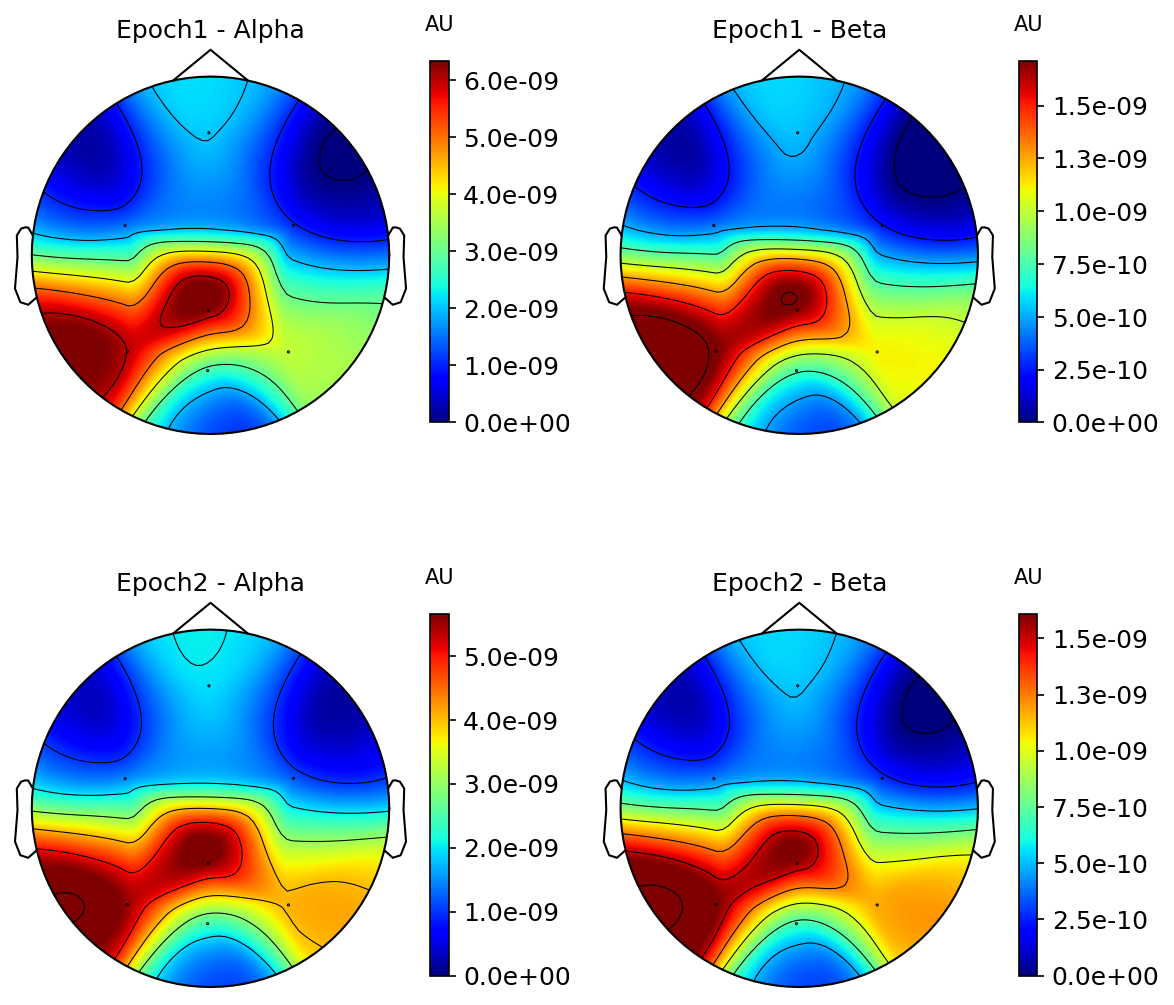

In [148]:
# plot TFRs
plt.style.use("default")
fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=150)
fig.tight_layout(pad=5.0)
topomap_kw = dict(ch_type="eeg", baseline=None, mode="logratio", show=False, cmap="jet")

alpha, beta = dict(fmin=8,  fmax=12), dict(fmin=13, fmax=30)

power1.plot_topomap(axes=ax[0, 0], **alpha, **topomap_kw)
power1.plot_topomap(axes=ax[0, 1], **beta, **topomap_kw)
ax[0, 0].set_title(f'Epoch1 - Alpha')
ax[0, 1].set_title(f'Epoch1 - Beta')

power2.plot_topomap(axes=ax[1, 0], **alpha, **topomap_kw)
power2.plot_topomap(axes=ax[1, 1], **beta, **topomap_kw)
ax[1, 0].set_title(f'Epoch2 - Alpha')
ax[1, 1].set_title(f'Epoch2 - Beta')

plt.tight_layout()
plt.show()